<a href="https://colab.research.google.com/github/gabriquaranta/drones-stuff/blob/main/adversarial_ataatack_tutorial_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FAST GRADIENT SIGN ATTACK

The Fast Gradient Sign Method (FGSM) is a technique used in adversarial machine learning to generate adversarial examples—inputs intentionally crafted to deceive neural networks into making incorrect predictions. Introduced by Goodfellow et al. in 2015, FGSM is notable for its simplicity and efficiency in creating such deceptive inputs.


**Understanding FGSM:**

- FGSM operates under a white-box attack scenario, meaning it requires full access to the target model's architecture and parameters.
  
- The method leverages the gradients of the model to identify the direction in which the input data should be altered to maximize the model's prediction error.

- By making minimal perturbations to the original input data, FGSM can induce significant misclassifications while keeping the changes imperceptible to humans.

**Mathematical Formulation:**

The FGSM algorithm perturbs the input data $ x $ by adding a small, carefully calculated noise $ \eta $ to create an adversarial example $ x' $. This perturbation is computed as follows:

$$ x' = x + \epsilon \cdot \text{sign}(\nabla_x J(\theta, x, y)) $$

Where:

- $ x $: Original input data

- $ y $: True label corresponding to $ x $

- $ \theta $: Model parameters

- $ J(\theta, x, y) $: Loss function used to train the model

- $ \nabla_x J(\theta, x, y) $: Gradient of the loss function with respect to the input $ x $

- $ \epsilon $: A small scalar value controlling the magnitude of the perturbation


The term $ \text{sign}(\nabla_x J(\theta, x, y)) $ represents the sign of the gradient of the loss function with respect to the input. By adding this scaled sign gradient to the original input, FGSM effectively increases the loss, leading the model to misclassify the perturbed input.
  

**Implementation Steps:**

1. **Compute the Loss:** Perform a forward pass with the input $ x $ to calculate the loss $ J(\theta, x, y) $ based on the true label $ y $.

  

2. **Calculate the Gradient:** Compute the gradient of the loss with respect to the input $ x $, denoted as $ \nabla_x J(\theta, x, y) $.
  

3. **Generate Perturbation:** Determine the perturbation by taking the sign of the computed gradient and scaling it by $ \epsilon $: $ \eta = \epsilon \cdot \text{sign}(\nabla_x J(\theta, x, y)) $.
  

4. **Create Adversarial Example:** Add the perturbation $ \eta $ to the original input $ x $ to obtain the adversarial example $ x' = x + \eta $.



## INPUTS

- **epsilons** - List of epsilon values to use for the run. It is important to keep 0 in the list because it represents the model performance on the original test set. Also, intuitively we would expect the larger the epsilon, the more noticeable the perturbations but the more effective the attack in terms of degrading model accuracy. Since the data range here is
[
0
,
1
]
[0,1], no epsilon value should exceed 1.

- **pretrained_model** - path to the pretrained MNIST model which was trained with pytorch/examples/mnist.

**link to pretrained model**: https://drive.google.com/file/d/1HJV2nUHJqclXQ8flKvcWmjZ-OU5DGatl/view?usp=drive_link

In [2]:
!gdown 1HJV2nUHJqclXQ8flKvcWmjZ-OU5DGatl

Downloading...
From: https://drive.google.com/uc?id=1HJV2nUHJqclXQ8flKvcWmjZ-OU5DGatl
To: /content/lenet_mnist_model.pth
100% 4.80M/4.80M [00:00<00:00, 32.8MB/s]


In [3]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "./lenet_mnist_model.pth"
# Set random seed for reproducibility
torch.manual_seed(42)

## MODEL

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [5]:
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location=device, weights_only=True))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 547kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.90MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 12.4MB/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Using cuda device


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## FGSM ATTACK

In [6]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [7]:
# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

## TEST

In [8]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [9]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9912 / 10000 = 0.9912
Epsilon: 0.05	Test Accuracy = 9605 / 10000 = 0.9605
Epsilon: 0.1	Test Accuracy = 8743 / 10000 = 0.8743
Epsilon: 0.15	Test Accuracy = 7110 / 10000 = 0.711
Epsilon: 0.2	Test Accuracy = 4877 / 10000 = 0.4877
Epsilon: 0.25	Test Accuracy = 2715 / 10000 = 0.2715
Epsilon: 0.3	Test Accuracy = 1416 / 10000 = 0.1416


## RESULTS

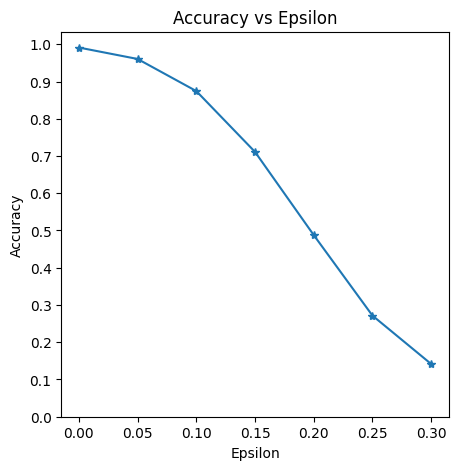

In [10]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

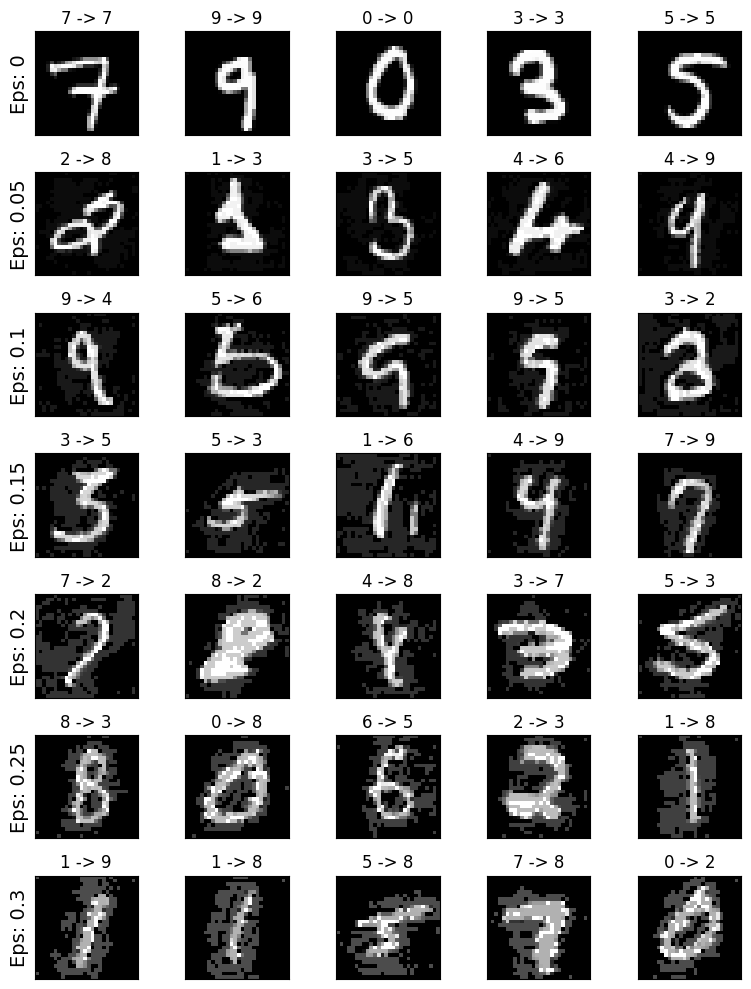

In [11]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()